In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn.modules.loss import *
from Loss.triplet import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
from validation import _AccuracyMeter
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter
from session import LossMeter, EvalModel
# %matplotlib notebook

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/drake/anaconda3/envs/.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [4]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

fulltrainset = torchvision.datasets.CIFAR10(root='/media/drake/MX500/Datasets/cifar-10/train', train=True,
                                        download=True, transform=transform)
trainset = torch.utils.data.dataset.Subset(fulltrainset, np.arange(12800))

fullvalset = torchvision.datasets.CIFAR10(root='/media/drake/MX500/Datasets/cifar-10/test', train=False,
                                       download=True, transform=transform)
valset = torch.utils.data.dataset.Subset(fullvalset, np.arange(12800))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(fullvalset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [6]:
class TripletRegularizedCrossEntropyLoss(nn.Module):
    def __init__(self, alpha, margin):     
        super().__init__()
        self.alpha = alpha
        self.margin = margin
        
    def forward(self, x, y):
        loss = F.cross_entropy(x[-1][0], y)
        triplet = 0
        if (self.alpha > 0):
            for layer in x[:-1]:
                # print(layer[0])
                triplet += batch_hard_triplet_loss(layer[0].view(layer[0].size(0), -1), y, self.margin)

            triplet *= self.alpha
            
        return loss + triplet

In [7]:
class CustomOneHotAccuracy(OneHotAccuracy):
    def __init__(self):
        super().__init__()
        self.reset()

    def update(self, output, label):
        return super().update(output[-1][0], label)

In [8]:
class EmbeddingSpaceValidator(TrainCallback):
    def __init__(self, val_data, num_embeddings, accuracy_meter_fn):
        self.val_data = val_data
        self.val_accuracy_meter = accuracy_meter_fn()
        self.train_accuracy_meter = accuracy_meter_fn()
        self.num_embeddings=num_embeddings
        
        self.train_accuracies = []
        self.batch_train_accuracies = []
        self.val_accuracies = []
        
        self.train_losses = []
        self.batch_train_losses = []
        self.train_bce_losses = []
        self.val_losses = []
        self.val_bce_losses = []
        
        self.batch_train_embedding_losses = [[] for x in range(self.num_embeddings)]
        self.val_embedding_losses = [[] for x in range(self.num_embeddings)]
        
        self.num_batches = 0
        self.num_epochs = 0
        
        self.epochs = []

    def run(self, session, lossMeter=None):
        self.val_accuracy_meter.reset()
            
        val_loss = LossMeter()
        val_bce_loss = LossMeter()
        embedding_losses = [LossMeter() for x in range(self.num_embeddings)]
        
        with EvalModel(session.model):
            for input, label, *_ in tqdm(self.val_data, desc="Validating", leave=True):
                label = Variable(util.to_gpu(label))
                output = session.forward(input)
                
                step_loss = session.criterion(output, label).data.cpu()
                
                val_loss.update(step_loss, input.shape[0])
                
                val_bce_loss.update(F.cross_entropy(output[-1][0], label).data.cpu(), input.shape[0])
                
                self.val_accuracy_meter.update(output, label)
                    
                for layer, embedding_loss in zip(output[:-1], embedding_losses):
                    embedding_loss.update(batch_all_triplet_loss(layer[0].view(layer[0].size(0), -1), label, 1).data.cpu())
        
        self.val_losses.append(val_loss.raw_avg.item())
        self.val_bce_losses.append(val_bce_loss.raw_avg.item())
         
        accuracy = self.val_accuracy_meter.accuracy()
        
        self.val_accuracies.append(accuracy)
              
        for meter, loss in zip(embedding_losses, self.val_embedding_losses):
            loss.append(meter.raw_avg)     
        
    def on_epoch_begin(self, session):
        self.train_accuracy_meter.reset()     
        self.train_bce_loss_meter = LossMeter()
        
    def on_epoch_end(self, session, lossMeter): 
        self.train_accuracies.append(self.train_accuracy_meter.accuracy())
        self.train_losses.append(lossMeter.debias.data.cpu().item())
        
        self.train_bce_losses.append(self.train_bce_loss_meter.raw_avg.data.cpu().item())
        
        self.run(session, lossMeter) 
        self.epochs.append(self.num_batches)
        self.num_epochs += 1
        
        print("\nval accuracy: ", round(self.val_accuracies[-1], 4),
              "\ntrain loss: ", round(self.train_losses[-1], 4) , 
              " train BCE : ", round(self.train_bce_losses[-1], 4) ,       
              "\nvalid loss: ", round(self.val_losses[-1], 4), 
              " valid BCE : ", round(self.val_bce_losses[-1], 4))
    
    def on_batch_end(self, session, lossMeter, output, label):
        label = Variable(util.to_gpu(label))
        batch_accuracy = self.train_accuracy_meter.update(output, label)
        self.batch_train_accuracies.append(batch_accuracy)
        self.batch_train_losses.append(lossMeter.loss.data.cpu().item())   
        self.train_bce_loss_meter.update(F.cross_entropy(output[-1][0], label).data.cpu(), label.shape[0])
             
        for layer, embedding_loss in zip(output[:-1], self.batch_train_embedding_losses):
            embedding_loss.append(batch_all_triplet_loss(layer[0].view(layer[0].size(0), -1), label, 1).data.cpu().item())
            
        self.num_batches += 1
            
    def plot(self):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))
        
        #ax.plot(np.arange(self.num_batches), self.batch_train_accuracies)
        #legend.append("Train accuracy per batch")
        
        #ax.plot(np.arange(self.num_batches), self.batch_train_losses)
        #legend.append("Train loss per batch")
            
        ax1.plot(self.epochs, self.train_accuracies, '-o', label="Training accuracy per epoch")

        ax1.plot(self.epochs, self.val_accuracies, '-o', label="Validation accuracy per epoch")
        
        ax2.plot(self.epochs, self.train_losses, '-o', label="Training loss per epoch")
        
        ax2.plot(self.epochs, self.val_losses, '-o', label="Validation loss per epoch")
        
        ax3.plot(self.epochs, self.train_bce_losses, '-o', label="Training BCE loss per epoch")
        
        ax3.plot(self.epochs, self.val_bce_losses, '-o', label="Validation BCE loss per epoch")
        
        for embedding in self.batch_train_embedding_losses:
            ax4.plot(np.arange(self.num_batches), embedding, label="Train embedding triplet loss per batch")
        
        for embedding in self.val_embedding_losses:
            ax4.plot(self.epochs, embedding, '-o', label="Validation embedding triplet loss per epoch")
            
        for ax in (ax1, ax2, ax3, ax4):
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

In [9]:
class SelectiveSequential(nn.Module):
    def __init__(self, to_select, modules_dict):
        super(SelectiveSequential, self).__init__()
        for key, module in modules_dict.items():
            self.add_module(key, module)
        self._to_select = to_select
    
    def forward(self, x):
        list = []
        for name, module in self._modules.items():
            x = module(x)
            if name in self._to_select:
                list.append((x, name))
        return list

In [10]:
resnet = torchvision.models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential()

#model = SelectiveSequential(
#    ['act1', 'act2', 'out'],
#    {'conv32a': resnet,
#       
#     'fc1': nn.Linear(num_ftrs, 1000),
#     'act1': nn.ReLU(True),
#     #'drop1': nn.Dropout(.05),
#     'fc2': nn.Linear(1000, 1000),
#     'act2': nn.ReLU(True),
#     #'drop1': nn.Dropout(.05),
#     'out': nn.Linear(1000, 10)})

model = SelectiveSequential(
    ['act1', 'act2', 'out'],
    {'conv32a': nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
     #'batch32a': nn.BatchNorm2d(32),
     'act32a': nn.ReLU(True),
    
     'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     #'batch32b': nn.BatchNorm2d(32),
     'act32b': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv64a': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     #'batch64a': nn.BatchNorm2d(64),
     'act64a': nn.ReLU(True),
     
     'conv64b': nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     #'batch64b': nn.BatchNorm2d(64),
     'act64b': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv128a': nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     #'batch128a': nn.BatchNorm2d(128),
     'act128a': nn.ReLU(True),
     
     'conv128b': nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     #'batch128b': nn.BatchNorm2d(128),
     'act128b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
    
     'fc1': nn.Linear(4 * 4 * 128, 512),
     'act1': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'fc2': nn.Linear(512, 256),
     'act2': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(256, 10)})

In [11]:
criterion = TripletRegularizedCrossEntropyLoss(0, .5)

In [12]:
sess = Session(model, criterion, optim.AdamW, 1e-4)

In [13]:
validator = EmbeddingSpaceValidator(valloader, 2, CustomOneHotAccuracy)
lr_scheduler = CosAnneal(len(trainloader) * 60, T_mult=1, lr_min=1e-7)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess.train(schedule, 60)

Validating: 100%|██████████| 313/313 [00:04<00:00, 65.24it/s]


val accuracy:  0.2714 
train loss:  1.9028  train BCE :  2.0414 
valid loss:  1.9392  valid BCE :  1.9392


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.30it/s]


val accuracy:  0.3883 
train loss:  1.707  train BCE :  1.7635 
valid loss:  1.6478  valid BCE :  1.6478


Validating: 100%|██████████| 313/313 [00:04<00:00, 64.60it/s]


val accuracy:  0.4217 
train loss:  1.557  train BCE :  1.6066 
valid loss:  1.56  valid BCE :  1.56


Validating: 100%|██████████| 313/313 [00:04<00:00, 67.95it/s]


val accuracy:  0.4573 
train loss:  1.4968  train BCE :  1.5108 
valid loss:  1.4836  valid BCE :  1.4836


Validating: 100%|██████████| 313/313 [00:04<00:00, 65.77it/s]



val accuracy:  0.4835 
train loss:  1.4135  train BCE :  1.4393 
valid loss:  1.4099  valid BCE :  1.4099


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.69it/s]


val accuracy:  0.4917 
train loss:  1.3808  train BCE :  1.374 
valid loss:  1.3806  valid BCE :  1.3806


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.31it/s]


val accuracy:  0.4994 
train loss:  1.2805  train BCE :  1.3237 
valid loss:  1.3625  valid BCE :  1.3625


Validating: 100%|██████████| 313/313 [00:04<00:00, 70.01it/s]


val accuracy:  0.5284 
train loss:  1.2737  train BCE :  1.2725 
valid loss:  1.3007  valid BCE :  1.3007


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.80it/s]


val accuracy:  0.5451 
train loss:  1.2143  train BCE :  1.2133 
valid loss:  1.2533  valid BCE :  1.2533


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.84it/s]


val accuracy:  0.534 
train loss:  1.1805  train BCE :  1.1709 
valid loss:  1.2846  valid BCE :  1.2846


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.49it/s]


val accuracy:  0.5639 
train loss:  1.091  train BCE :  1.1156 
valid loss:  1.2053  valid BCE :  1.2053


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.83it/s]


val accuracy:  0.5726 
train loss:  1.0761  train BCE :  1.0733 
valid loss:  1.1896  valid BCE :  1.1896


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.57it/s]


val accuracy:  0.5624 
train loss:  0.9808  train BCE :  1.018 
valid loss:  1.2296  valid BCE :  1.2296


Validating: 100%|██████████| 313/313 [00:04<00:00, 66.82it/s]


val accuracy:  0.5893 
train loss:  0.9774  train BCE :  0.9742 
valid loss:  1.1584  valid BCE :  1.1584


Validating: 100%|██████████| 313/313 [00:04<00:00, 67.04it/s]


val accuracy:  0.5974 
train loss:  0.9292  train BCE :  0.9317 
valid loss:  1.1176  valid BCE :  1.1176


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.24it/s]


val accuracy:  0.6034 
train loss:  0.9001  train BCE :  0.8736 
valid loss:  1.113  valid BCE :  1.113


Validating: 100%|██████████| 313/313 [00:04<00:00, 65.01it/s]


val accuracy:  0.6075 
train loss:  0.8166  train BCE :  0.8273 
valid loss:  1.122  valid BCE :  1.122


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.07it/s]


val accuracy:  0.6101 
train loss:  0.8016  train BCE :  0.7818 
valid loss:  1.1272  valid BCE :  1.1272


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.52it/s]


val accuracy:  0.6092 
train loss:  0.7365  train BCE :  0.728 
valid loss:  1.1566  valid BCE :  1.1566


Validating: 100%|██████████| 313/313 [00:04<00:00, 66.21it/s]


val accuracy:  0.5908 
train loss:  0.6934  train BCE :  0.6743 
valid loss:  1.2223  valid BCE :  1.2223


Validating: 100%|██████████| 313/313 [00:04<00:00, 67.31it/s]


val accuracy:  0.6101 
train loss:  0.6391  train BCE :  0.6341 
valid loss:  1.1905  valid BCE :  1.1905


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.23it/s]


val accuracy:  0.6086 
train loss:  0.5866  train BCE :  0.5755 
valid loss:  1.2716  valid BCE :  1.2716


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.02it/s]


val accuracy:  0.6126 
train loss:  0.5417  train BCE :  0.5251 
valid loss:  1.2704  valid BCE :  1.2704


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.63it/s]


val accuracy:  0.6193 
train loss:  0.4637  train BCE :  0.4697 
valid loss:  1.3005  valid BCE :  1.3005


Validating: 100%|██████████| 313/313 [00:04<00:00, 67.23it/s]


val accuracy:  0.6171 
train loss:  0.4238  train BCE :  0.4164 
valid loss:  1.3523  valid BCE :  1.3523


Validating: 100%|██████████| 313/313 [00:05<00:00, 61.14it/s]


val accuracy:  0.6191 
train loss:  0.3602  train BCE :  0.3722 
valid loss:  1.4066  valid BCE :  1.4066


Validating: 100%|██████████| 313/313 [00:05<00:00, 61.20it/s]


val accuracy:  0.6147 
train loss:  0.3407  train BCE :  0.3192 
valid loss:  1.4587  valid BCE :  1.4587


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.31it/s]


val accuracy:  0.6157 
train loss:  0.2737  train BCE :  0.2754 
valid loss:  1.5859  valid BCE :  1.5859


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.21it/s]


val accuracy:  0.614 
train loss:  0.2418  train BCE :  0.2268 
valid loss:  1.6805  valid BCE :  1.6805


Validating: 100%|██████████| 313/313 [00:04<00:00, 66.21it/s]


val accuracy:  0.6133 
train loss:  0.1991  train BCE :  0.1958 
valid loss:  1.7619  valid BCE :  1.7619


Validating: 100%|██████████| 313/313 [00:04<00:00, 70.11it/s]


val accuracy:  0.6102 
train loss:  0.1913  train BCE :  0.164 
valid loss:  1.872  valid BCE :  1.872


Validating: 100%|██████████| 313/313 [00:04<00:00, 70.83it/s]


val accuracy:  0.6018 
train loss:  0.1321  train BCE :  0.1279 
valid loss:  2.0239  valid BCE :  2.0239


Validating: 100%|██████████| 313/313 [00:04<00:00, 70.23it/s]


val accuracy:  0.6081 
train loss:  0.1077  train BCE :  0.1041 
valid loss:  2.0886  valid BCE :  2.0886


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.26it/s]


val accuracy:  0.6141 
train loss:  0.0857  train BCE :  0.0786 
valid loss:  2.2543  valid BCE :  2.2543


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.75it/s]


val accuracy:  0.6146 
train loss:  0.0725  train BCE :  0.0623 
valid loss:  2.3586  valid BCE :  2.3586


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.10it/s]



val accuracy:  0.6082 
train loss:  0.0573  train BCE :  0.049 
valid loss:  2.4495  valid BCE :  2.4495


Validating: 100%|██████████| 313/313 [00:04<00:00, 66.18it/s]


val accuracy:  0.6032 
train loss:  0.0416  train BCE :  0.0359 
valid loss:  2.6292  valid BCE :  2.6292


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.59it/s]


val accuracy:  0.605 
train loss:  0.037  train BCE :  0.0269 
valid loss:  2.7344  valid BCE :  2.7344


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.63it/s]


val accuracy:  0.6111 
train loss:  0.0186  train BCE :  0.0213 
valid loss:  2.833  valid BCE :  2.833


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.94it/s]


val accuracy:  0.6124 
train loss:  0.0149  train BCE :  0.0141 
valid loss:  2.9492  valid BCE :  2.9492


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.40it/s]


val accuracy:  0.6035 
train loss:  0.028  train BCE :  0.014 
valid loss:  3.0769  valid BCE :  3.0769


Validating: 100%|██████████| 313/313 [00:04<00:00, 66.83it/s]


val accuracy:  0.6138 
train loss:  0.0101  train BCE :  0.0124 
valid loss:  3.1176  valid BCE :  3.1176


Validating: 100%|██████████| 313/313 [00:04<00:00, 66.15it/s]



val accuracy:  0.6121 
train loss:  0.0053  train BCE :  0.0065 
valid loss:  3.2065  valid BCE :  3.2065


Validating: 100%|██████████| 313/313 [00:04<00:00, 62.63it/s]


val accuracy:  0.6106 
train loss:  0.0054  train BCE :  0.0048 
valid loss:  3.3135  valid BCE :  3.3135


Validating: 100%|██████████| 313/313 [00:04<00:00, 65.55it/s]


val accuracy:  0.6131 
train loss:  0.0039  train BCE :  0.0043 
valid loss:  3.3798  valid BCE :  3.3798


Validating: 100%|██████████| 313/313 [00:04<00:00, 67.36it/s]


val accuracy:  0.6111 
train loss:  0.0033  train BCE :  0.0034 
valid loss:  3.4599  valid BCE :  3.4599


Validating: 100%|██████████| 313/313 [00:04<00:00, 70.45it/s]


val accuracy:  0.6106 
train loss:  0.0028  train BCE :  0.0029 
valid loss:  3.5327  valid BCE :  3.5327


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.71it/s]


val accuracy:  0.6101 
train loss:  0.0025  train BCE :  0.0024 
valid loss:  3.587  valid BCE :  3.587


Validating: 100%|██████████| 313/313 [00:05<00:00, 61.71it/s]


val accuracy:  0.6114 
train loss:  0.0021  train BCE :  0.0021 
valid loss:  3.659  valid BCE :  3.659


Validating: 100%|██████████| 313/313 [00:04<00:00, 70.09it/s]


val accuracy:  0.6099 
train loss:  0.0018  train BCE :  0.0019 
valid loss:  3.7042  valid BCE :  3.7042


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.54it/s]


val accuracy:  0.6101 
train loss:  0.0017  train BCE :  0.0017 
valid loss:  3.7555  valid BCE :  3.7555


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.93it/s]


val accuracy:  0.6119 
train loss:  0.0015  train BCE :  0.0015 
valid loss:  3.7943  valid BCE :  3.7943


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.23it/s]


val accuracy:  0.6099 
train loss:  0.0014  train BCE :  0.0014 
valid loss:  3.8381  valid BCE :  3.8381


Validating: 100%|██████████| 313/313 [00:04<00:00, 67.40it/s]


val accuracy:  0.6107 
train loss:  0.0013  train BCE :  0.0013 
valid loss:  3.8723  valid BCE :  3.8723


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.27it/s]


val accuracy:  0.6108 
train loss:  0.0012  train BCE :  0.0012 
valid loss:  3.8891  valid BCE :  3.8891


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.43it/s]


val accuracy:  0.6105 
train loss:  0.0012  train BCE :  0.0011 
valid loss:  3.9163  valid BCE :  3.9163


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.42it/s]


val accuracy:  0.6103 
train loss:  0.0011  train BCE :  0.0011 
valid loss:  3.9284  valid BCE :  3.9284


Validating: 100%|██████████| 313/313 [00:04<00:00, 68.76it/s]


val accuracy:  0.6109 
train loss:  0.0011  train BCE :  0.0011 
valid loss:  3.9403  valid BCE :  3.9403


Validating: 100%|██████████| 313/313 [00:04<00:00, 70.61it/s]


val accuracy:  0.6104 
train loss:  0.0011  train BCE :  0.001 
valid loss:  3.9446  valid BCE :  3.9446


Validating: 100%|██████████| 313/313 [00:04<00:00, 69.04it/s]


val accuracy:  0.6105 
train loss:  0.0011  train BCE :  0.001 
valid loss:  3.9471  valid BCE :  3.9471



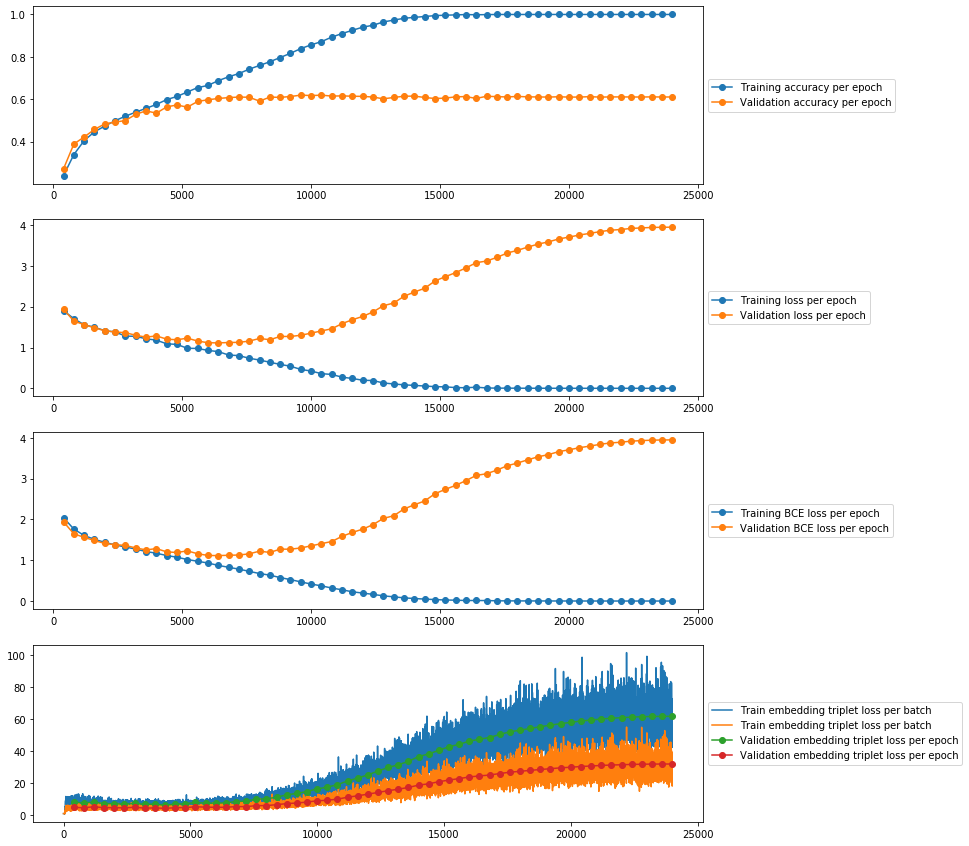

In [14]:
validator.plot()

In [15]:
print(np.max(validator.val_accuracies), " Best validation accuracy without reg")
print(np.max(validator.train_accuracies), " Best train accuracy without reg")

0.6193  Best validation accuracy without reg
1.0  Best train accuracy without reg


resnet2 = torchvision.models.resnet18(pretrained=False)
num_ftrs = resnet2.fc.in_features
resnet2.fc = nn.Sequential()

model2 = SelectiveSequential(
    ['act1', 'act2', 'out'],
    {'conv32a': resnet2,
       
     'fc1': nn.Linear(num_ftrs, 1000),
     'act1': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'fc2': nn.Linear(1000, 1000),
     'act2': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(1000, 10)})

In [16]:
model2 = SelectiveSequential(
    ['act1', 'act2', 'out'],
    {'conv32a': nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
     #'batch32a': nn.BatchNorm2d(32),
     'act32a': nn.ReLU(True),
    
     'conv32b': nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
     #'batch32b': nn.BatchNorm2d(32),
     'act32b': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv64a': nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
     #'batch64a': nn.BatchNorm2d(64),
     'act64a': nn.ReLU(True),
     
     'conv64b': nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
     #'batch64b': nn.BatchNorm2d(64),
     'act64b': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv128a': nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
     #'batch128a': nn.BatchNorm2d(128),
     'act128a': nn.ReLU(True),
     
     'conv128b': nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
     #'batch128b': nn.BatchNorm2d(128),
     'act128b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
    
     'fc1': nn.Linear(4 * 4 * 128, 512),
     'act1': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'fc2': nn.Linear(512, 256),
     'act2': nn.ReLU(True),
     #'drop1': nn.Dropout(.05),
     'out': nn.Linear(256, 10)})

In [17]:
criterion = TripletRegularizedCrossEntropyLoss(0.05, .5)

In [18]:
sess = Session(model2, criterion, optim.AdamW, 1e-4)

In [19]:
# lr_find(sess, trainloader, start_lr=1e-12)

In [20]:
# sess.set_lr(1e-2)

In [21]:
validator2 = EmbeddingSpaceValidator(valloader, 2, CustomOneHotAccuracy)
lr_scheduler2 = CosAnneal(len(trainloader) * 60, T_mult=1, lr_min=1e-7)
schedule2 = TrainingSchedule(trainloader, [validator2])
sess.train(schedule2, 60)

Validating: 100%|██████████| 313/313 [00:05<00:00, 57.51it/s]


val accuracy:  0.1 
train loss:  2.3528  train BCE :  2.3029 
valid loss:  2.3527  valid BCE :  2.3024


Validating: 100%|██████████| 313/313 [00:05<00:00, 56.42it/s]


val accuracy:  0.416 
train loss:  1.9385  train BCE :  2.049 
valid loss:  1.8724  valid BCE :  1.6049


Validating: 100%|██████████| 313/313 [00:05<00:00, 55.57it/s]


val accuracy:  0.4822 
train loss:  1.6743  train BCE :  1.4843 
valid loss:  1.683  valid BCE :  1.4462


Validating: 100%|██████████| 313/313 [00:05<00:00, 54.09it/s]


val accuracy:  0.5341 
train loss:  1.5356  train BCE :  1.3219 
valid loss:  1.5204  valid BCE :  1.2923


Validating: 100%|██████████| 313/313 [00:05<00:00, 56.31it/s]



val accuracy:  0.5694 
train loss:  1.4289  train BCE :  1.1998 
valid loss:  1.4384  valid BCE :  1.2261


Validating: 100%|██████████| 313/313 [00:05<00:00, 58.98it/s]


val accuracy:  0.5918 
train loss:  1.3285  train BCE :  1.1135 
valid loss:  1.3575  valid BCE :  1.1323


Validating: 100%|██████████| 313/313 [00:05<00:00, 59.81it/s]



val accuracy:  0.6077 
train loss:  1.1922  train BCE :  1.0271 
valid loss:  1.3053  valid BCE :  1.0957


Validating: 100%|██████████| 313/313 [00:05<00:00, 58.92it/s]


val accuracy:  0.6331 
train loss:  1.161  train BCE :  0.9635 
valid loss:  1.2525  valid BCE :  1.0412


Validating: 100%|██████████| 313/313 [00:05<00:00, 59.31it/s]


val accuracy:  0.655 
train loss:  1.0812  train BCE :  0.8965 
valid loss:  1.1886  valid BCE :  0.9925


Validating: 100%|██████████| 313/313 [00:05<00:00, 57.65it/s]


val accuracy:  0.6486 
train loss:  0.9959  train BCE :  0.8221 
valid loss:  1.206  valid BCE :  1.0144


Validating: 100%|██████████| 313/313 [00:05<00:00, 58.30it/s]


val accuracy:  0.6694 
train loss:  0.9212  train BCE :  0.7681 
valid loss:  1.1416  valid BCE :  0.9497


Validating: 100%|██████████| 313/313 [00:05<00:00, 53.29it/s]


val accuracy:  0.6682 
train loss:  0.8775  train BCE :  0.7047 
valid loss:  1.1517  valid BCE :  0.9557


Validating: 100%|██████████| 313/313 [00:05<00:00, 58.59it/s]


val accuracy:  0.6793 
train loss:  0.7988  train BCE :  0.6499 
valid loss:  1.1299  valid BCE :  0.9338


Validating: 100%|██████████| 313/313 [00:05<00:00, 55.18it/s]


val accuracy:  0.6806 
train loss:  0.774  train BCE :  0.5975 
valid loss:  1.1029  valid BCE :  0.9186


Validating: 100%|██████████| 313/313 [00:06<00:00, 50.19it/s]


val accuracy:  0.6769 
train loss:  0.6823  train BCE :  0.5405 
valid loss:  1.1509  valid BCE :  0.9493


Validating: 100%|██████████| 313/313 [00:06<00:00, 48.44it/s]


val accuracy:  0.6691 
train loss:  0.619  train BCE :  0.482 
valid loss:  1.1613  valid BCE :  0.9679


Validating: 100%|██████████| 313/313 [00:06<00:00, 46.90it/s]


val accuracy:  0.6833 
train loss:  0.589  train BCE :  0.4232 
valid loss:  1.1402  valid BCE :  0.9412


Validating: 100%|██████████| 313/313 [00:06<00:00, 46.59it/s]



val accuracy:  0.6905 
train loss:  0.5263  train BCE :  0.3729 
valid loss:  1.1692  valid BCE :  0.9644


Validating: 100%|██████████| 313/313 [00:06<00:00, 48.18it/s]


val accuracy:  0.6822 
train loss:  0.449  train BCE :  0.3144 
valid loss:  1.2302  valid BCE :  1.0121


Validating: 100%|██████████| 313/313 [00:06<00:00, 47.48it/s]


val accuracy:  0.6799 
train loss:  0.3806  train BCE :  0.2561 
valid loss:  1.2859  valid BCE :  1.068


Validating: 100%|██████████| 313/313 [00:06<00:00, 52.07it/s]


val accuracy:  0.6744 
train loss:  0.3342  train BCE :  0.2052 
valid loss:  1.3336  valid BCE :  1.1109


Validating: 100%|██████████| 313/313 [00:05<00:00, 53.08it/s]


val accuracy:  0.6852 
train loss:  0.2913  train BCE :  0.1682 
valid loss:  1.2956  valid BCE :  1.0774


Validating: 100%|██████████| 313/313 [00:05<00:00, 53.43it/s]


val accuracy:  0.6789 
train loss:  0.2513  train BCE :  0.1211 
valid loss:  1.3961  valid BCE :  1.1675


Validating: 100%|██████████| 313/313 [00:05<00:00, 53.52it/s]


val accuracy:  0.6821 
train loss:  0.2081  train BCE :  0.0926 
valid loss:  1.421  valid BCE :  1.1887


Validating: 100%|██████████| 313/313 [00:06<00:00, 51.80it/s]



val accuracy:  0.6846 
train loss:  0.1684  train BCE :  0.0661 
valid loss:  1.544  valid BCE :  1.2956


Validating: 100%|██████████| 313/313 [00:06<00:00, 51.81it/s]



val accuracy:  0.6869 
train loss:  0.1356  train BCE :  0.0487 
valid loss:  1.5002  valid BCE :  1.2631


Validating: 100%|██████████| 313/313 [00:05<00:00, 52.60it/s]



val accuracy:  0.6849 
train loss:  0.1178  train BCE :  0.034 
valid loss:  1.5971  valid BCE :  1.3542


Validating: 100%|██████████| 313/313 [00:06<00:00, 50.68it/s]


val accuracy:  0.6866 
train loss:  0.0843  train BCE :  0.0223 
valid loss:  1.6256  valid BCE :  1.3771


Validating: 100%|██████████| 313/313 [00:06<00:00, 49.33it/s]



val accuracy:  0.672 
train loss:  0.0731  train BCE :  0.0144 
valid loss:  1.7659  valid BCE :  1.5122


Validating: 100%|██████████| 313/313 [00:06<00:00, 49.11it/s]


val accuracy:  0.6832 
train loss:  0.1385  train BCE :  0.0494 
valid loss:  1.5215  valid BCE :  1.2982


Validating: 100%|██████████| 313/313 [00:06<00:00, 50.37it/s]


val accuracy:  0.6918 
train loss:  0.0566  train BCE :  0.0139 
valid loss:  1.5809  valid BCE :  1.3481


Validating: 100%|██████████| 313/313 [00:05<00:00, 52.34it/s]


val accuracy:  0.6928 
train loss:  0.0473  train BCE :  0.0064 
valid loss:  1.5948  valid BCE :  1.364


Validating: 100%|██████████| 313/313 [00:05<00:00, 55.57it/s]


val accuracy:  0.6955 
train loss:  0.0386  train BCE :  0.0048 
valid loss:  1.6764  valid BCE :  1.4352


Validating: 100%|██████████| 313/313 [00:05<00:00, 52.99it/s]


val accuracy:  0.6877 
train loss:  0.0424  train BCE :  0.0049 
valid loss:  1.7492  valid BCE :  1.5034


Validating: 100%|██████████| 313/313 [00:05<00:00, 52.85it/s]


val accuracy:  0.687 
train loss:  0.0981  train BCE :  0.0691 
valid loss:  1.696  valid BCE :  1.4627


Validating: 100%|██████████| 313/313 [00:06<00:00, 48.95it/s]


val accuracy:  0.6975 
train loss:  0.0361  train BCE :  0.0064 
valid loss:  1.6012  valid BCE :  1.3777


Validating: 100%|██████████| 313/313 [00:06<00:00, 49.61it/s]


val accuracy:  0.6973 
train loss:  0.0296  train BCE :  0.0024 
valid loss:  1.6339  valid BCE :  1.4075


Validating: 100%|██████████| 313/313 [00:05<00:00, 52.90it/s]


val accuracy:  0.6971 
train loss:  0.0266  train BCE :  0.0018 
valid loss:  1.7031  valid BCE :  1.4688


Validating: 100%|██████████| 313/313 [00:06<00:00, 51.62it/s]


val accuracy:  0.6983 
train loss:  0.0244  train BCE :  0.0016 
valid loss:  1.6932  valid BCE :  1.4612


Validating: 100%|██████████| 313/313 [00:06<00:00, 50.46it/s]


val accuracy:  0.6994 
train loss:  0.0244  train BCE :  0.0016 
valid loss:  1.6703  valid BCE :  1.4433


Validating: 100%|██████████| 313/313 [00:05<00:00, 52.41it/s]


val accuracy:  0.6955 
train loss:  0.0232  train BCE :  0.0015 
valid loss:  1.7059  valid BCE :  1.4797


Validating: 100%|██████████| 313/313 [00:05<00:00, 53.51it/s]


val accuracy:  0.6825 
train loss:  0.194  train BCE :  0.0707 
valid loss:  1.5835  valid BCE :  1.375


Validating: 100%|██████████| 313/313 [00:06<00:00, 49.27it/s]


val accuracy:  0.6908 
train loss:  0.0494  train BCE :  0.0223 
valid loss:  1.6988  valid BCE :  1.4786


Validating: 100%|██████████| 313/313 [00:06<00:00, 49.63it/s]


val accuracy:  0.6977 
train loss:  0.0211  train BCE :  0.0017 
valid loss:  1.7132  valid BCE :  1.4885


Validating: 100%|██████████| 313/313 [00:06<00:00, 51.81it/s]


val accuracy:  0.7014 
train loss:  0.0176  train BCE :  0.0009 
valid loss:  1.7578  valid BCE :  1.528


Validating: 100%|██████████| 313/313 [00:05<00:00, 52.35it/s]


val accuracy:  0.7008 
train loss:  0.016  train BCE :  0.0007 
valid loss:  1.7551  valid BCE :  1.5257


Validating: 100%|██████████| 313/313 [00:06<00:00, 51.06it/s]


val accuracy:  0.6989 
train loss:  0.0161  train BCE :  0.0006 
valid loss:  1.7647  valid BCE :  1.5368


Validating: 100%|██████████| 313/313 [00:06<00:00, 50.47it/s]


val accuracy:  0.7007 
train loss:  0.0144  train BCE :  0.0006 
valid loss:  1.8168  valid BCE :  1.5824


Validating: 100%|██████████| 313/313 [00:06<00:00, 50.11it/s]


val accuracy:  0.6984 
train loss:  0.0139  train BCE :  0.0005 
valid loss:  1.8315  valid BCE :  1.598


Validating: 100%|██████████| 313/313 [00:06<00:00, 49.95it/s]


val accuracy:  0.69 
train loss:  0.0134  train BCE :  0.0005 
valid loss:  1.8791  valid BCE :  1.6405


Validating: 100%|██████████| 313/313 [00:06<00:00, 51.94it/s]



val accuracy:  0.694 
train loss:  0.0143  train BCE :  0.0007 
valid loss:  1.9708  valid BCE :  1.7214


Validating: 100%|██████████| 313/313 [00:06<00:00, 49.58it/s]


val accuracy:  0.682 
train loss:  0.1029  train BCE :  0.1012 
valid loss:  1.6752  valid BCE :  1.4657


Validating: 100%|██████████| 313/313 [00:05<00:00, 55.31it/s]


val accuracy:  0.6999 
train loss:  0.0184  train BCE :  0.005 
valid loss:  1.7754  valid BCE :  1.5524


Validating: 100%|██████████| 313/313 [00:05<00:00, 54.25it/s]


val accuracy:  0.699 
train loss:  0.012  train BCE :  0.0006 
valid loss:  1.8018  valid BCE :  1.5753


Validating: 100%|██████████| 313/313 [00:06<00:00, 47.27it/s]



val accuracy:  0.6981 
train loss:  0.0107  train BCE :  0.0004 
valid loss:  1.8274  valid BCE :  1.5975


Validating: 100%|██████████| 313/313 [00:06<00:00, 50.17it/s]


val accuracy:  0.6986 
train loss:  0.0103  train BCE :  0.0003 
valid loss:  1.8126  valid BCE :  1.5852


Validating: 100%|██████████| 313/313 [00:06<00:00, 45.51it/s]


val accuracy:  0.6975 
train loss:  0.0089  train BCE :  0.0002 
valid loss:  1.8297  valid BCE :  1.6


Validating: 100%|██████████| 313/313 [00:06<00:00, 50.22it/s]



val accuracy:  0.6985 
train loss:  0.0081  train BCE :  0.0002 
valid loss:  1.87  valid BCE :  1.636


Validating: 100%|██████████| 313/313 [00:06<00:00, 49.99it/s]


val accuracy:  0.6976 
train loss:  0.0075  train BCE :  0.0002 
valid loss:  1.9571  valid BCE :  1.7156


Validating: 100%|██████████| 313/313 [00:06<00:00, 49.32it/s]


val accuracy:  0.697 
train loss:  0.0079  train BCE :  0.0002 
valid loss:  2.002  valid BCE :  1.7544



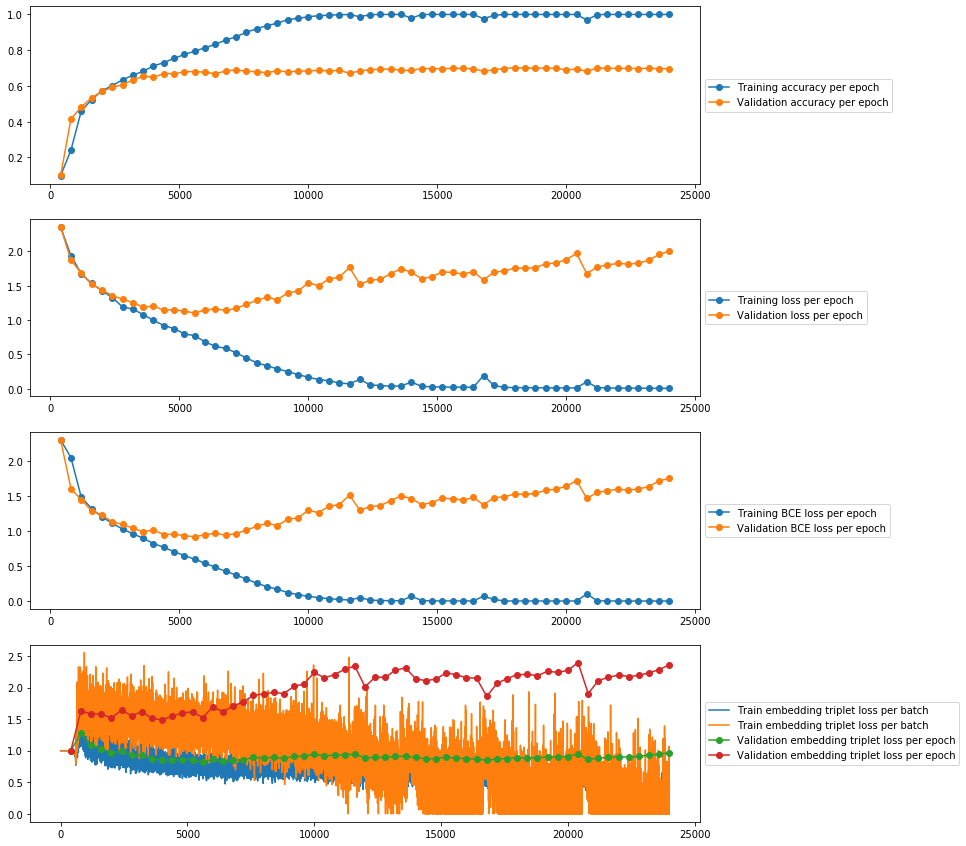

In [24]:
validator2.plot()

In [25]:
print(np.max(validator2.val_accuracies), "Best accuracy with reg")
print(np.max(validator.val_accuracies), "Best accuracy without reg")

0.7014 Best accuracy with reg
0.6193 Best accuracy without reg
